In [1]:
import tensorflow as tf                  # TensorFlow

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D, AveragePooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-15 09:58:17.602280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2115, 22, 1000)


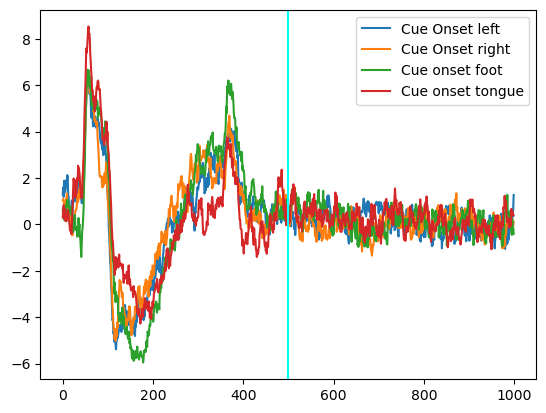

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 400, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


## Preprocessing the dataset

X_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
X_valid_prep = test_data_prep(x_valid) 
X_test_prep = test_data_prep(X_test) 

print('\n')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = X_train_prep.reshape(X_train_prep.shape[0], X_train_prep.shape[1], X_train_prep.shape[2], 1)
x_valid = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

print('\n')


# Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
# x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
# x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
# x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1715, 22, 1000)
Shape of validation set: (400, 22, 1000)
Shape of training labels: (1715,)
Shape of validation labels: (400,)
Shape of X after trimming: (1715, 22, 500)
Shape of X after maxpooling: (1715, 22, 250)
Shape of X after averaging+noise and concatenating: (3430, 22, 250)
Shape of X after subsampling and concatenating: (6860, 22, 250)
Shape of Y: (6860,)
Shape of X after trimming: (400, 22, 500)
Shape of X after maxpooling: (400, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


Shape of training labels after categorical conversion: (6860, 4)
Shape of validation labels after categorical conversion: (400, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (6860, 22, 250, 1)
Shape of validation set after adding width info: (400, 22, 250, 1)
Shape of test set after adding width info: (443, 22, 250, 1)




In [5]:
# Building the CNN model using sequential class
cnn_model = Sequential()

# Conv. block 1
cnn_model.add(Conv2D(filters=25, kernel_size=(1,64), padding='same',\
                                 input_shape=(22,250,1)))

cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=50, kernel_size=(22,1), padding='valid'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('elu'))
cnn_model.add(AveragePooling2D(pool_size=(1,4), padding='same')) # Read the keras documentation
cnn_model.add(Dropout(0.4))


# Conv. block 2
cnn_model.add(Conv2D(filters=100, kernel_size=(1,16), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('elu'))
cnn_model.add(AveragePooling2D(pool_size=(1,8), padding='same'))
cnn_model.add(Dropout(0.4))


# FC+LSTM layers
cnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
cnn_model.add(Dropout(0.6))


# Output layer with Softmax activation 
cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 250, 25)       1625      
                                                                 
 batch_normalization (Batch  (None, 22, 250, 25)       100       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 250, 50)        27550     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 250, 50)        200       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 1, 250, 50)        0         
                                                                 
 average_pooling2d (Average  (None, 1, 63, 50)         0

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime

# run this cell to clear all previous logs
!rm -rf ./logs/

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 5, factor = 0.2, cooldown=5,
    min_lr=0.00001)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models1/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)

In [8]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[tb_callback, lr_callback, save_cb], verbose=True)




Epoch 1/100
108/108 [==============================] - ETA: 0s - loss: 1.4105 - accuracy: 0.3755INFO:tensorflow:Assets written to: models4/checkpoint_01_1.21/assets


INFO:tensorflow:Assets written to: models4/checkpoint_01_1.21/assets


108/108 [==============================] - 32s 283ms/step - loss: 1.4105 - accuracy: 0.3755 - val_loss: 1.2051 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 1.1573 - accuracy: 0.5073INFO:tensorflow:Assets written to: models4/checkpoint_02_1.09/assets


INFO:tensorflow:Assets written to: models4/checkpoint_02_1.09/assets


108/108 [==============================] - 31s 283ms/step - loss: 1.1573 - accuracy: 0.5073 - val_loss: 1.0852 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 1.0655 - accuracy: 0.5598INFO:tensorflow:Assets written to: models4/checkpoint_03_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_03_1.01/assets


108/108 [==============================] - 30s 282ms/step - loss: 1.0655 - accuracy: 0.5598 - val_loss: 1.0125 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.5907INFO:tensorflow:Assets written to: models4/checkpoint_04_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_04_1.01/assets


108/108 [==============================] - 30s 274ms/step - loss: 0.9886 - accuracy: 0.5907 - val_loss: 1.0056 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 5/100
108/108 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.6238INFO:tensorflow:Assets written to: models4/checkpoint_05_0.97/assets


INFO:tensorflow:Assets written to: models4/checkpoint_05_0.97/assets


108/108 [==============================] - 30s 274ms/step - loss: 0.9263 - accuracy: 0.6238 - val_loss: 0.9662 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 6/100
108/108 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.6410INFO:tensorflow:Assets written to: models4/checkpoint_06_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_06_1.01/assets


108/108 [==============================] - 29s 273ms/step - loss: 0.8827 - accuracy: 0.6410 - val_loss: 1.0077 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 7/100
108/108 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.6727INFO:tensorflow:Assets written to: models4/checkpoint_07_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_07_0.91/assets


108/108 [==============================] - 29s 273ms/step - loss: 0.8236 - accuracy: 0.6727 - val_loss: 0.9063 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 8/100
108/108 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.6859INFO:tensorflow:Assets written to: models4/checkpoint_08_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_08_0.91/assets


108/108 [==============================] - 30s 276ms/step - loss: 0.7906 - accuracy: 0.6859 - val_loss: 0.9108 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 9/100
108/108 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.6876INFO:tensorflow:Assets written to: models4/checkpoint_09_0.84/assets


INFO:tensorflow:Assets written to: models4/checkpoint_09_0.84/assets


108/108 [==============================] - 30s 281ms/step - loss: 0.7851 - accuracy: 0.6876 - val_loss: 0.8390 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 10/100
108/108 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.6974INFO:tensorflow:Assets written to: models4/checkpoint_10_0.85/assets


INFO:tensorflow:Assets written to: models4/checkpoint_10_0.85/assets


108/108 [==============================] - 30s 279ms/step - loss: 0.7613 - accuracy: 0.6974 - val_loss: 0.8474 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 11/100
108/108 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7173INFO:tensorflow:Assets written to: models4/checkpoint_11_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_11_0.86/assets


108/108 [==============================] - 30s 280ms/step - loss: 0.7120 - accuracy: 0.7173 - val_loss: 0.8602 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 12/100
108/108 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.7243INFO:tensorflow:Assets written to: models4/checkpoint_12_0.82/assets


INFO:tensorflow:Assets written to: models4/checkpoint_12_0.82/assets


108/108 [==============================] - 31s 285ms/step - loss: 0.7058 - accuracy: 0.7243 - val_loss: 0.8172 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 13/100
108/108 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.7395INFO:tensorflow:Assets written to: models4/checkpoint_13_0.82/assets


INFO:tensorflow:Assets written to: models4/checkpoint_13_0.82/assets


108/108 [==============================] - 31s 285ms/step - loss: 0.6860 - accuracy: 0.7395 - val_loss: 0.8196 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 14/100
108/108 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7386INFO:tensorflow:Assets written to: models4/checkpoint_14_0.81/assets


INFO:tensorflow:Assets written to: models4/checkpoint_14_0.81/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.6613 - accuracy: 0.7386 - val_loss: 0.8077 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 15/100
108/108 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7464INFO:tensorflow:Assets written to: models4/checkpoint_15_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_15_0.76/assets


108/108 [==============================] - 31s 288ms/step - loss: 0.6532 - accuracy: 0.7464 - val_loss: 0.7638 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 16/100
108/108 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.7531INFO:tensorflow:Assets written to: models4/checkpoint_16_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_16_0.76/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.6346 - accuracy: 0.7531 - val_loss: 0.7641 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 17/100
108/108 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7561INFO:tensorflow:Assets written to: models4/checkpoint_17_0.79/assets


INFO:tensorflow:Assets written to: models4/checkpoint_17_0.79/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.6337 - accuracy: 0.7561 - val_loss: 0.7908 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 18/100
108/108 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7682INFO:tensorflow:Assets written to: models4/checkpoint_18_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_18_0.76/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.6055 - accuracy: 0.7682 - val_loss: 0.7616 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 19/100
108/108 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7599INFO:tensorflow:Assets written to: models4/checkpoint_19_0.78/assets


INFO:tensorflow:Assets written to: models4/checkpoint_19_0.78/assets


108/108 [==============================] - 31s 291ms/step - loss: 0.6084 - accuracy: 0.7599 - val_loss: 0.7776 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 20/100
108/108 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7681INFO:tensorflow:Assets written to: models4/checkpoint_20_0.77/assets


INFO:tensorflow:Assets written to: models4/checkpoint_20_0.77/assets


108/108 [==============================] - 31s 289ms/step - loss: 0.5954 - accuracy: 0.7681 - val_loss: 0.7666 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 21/100
108/108 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7800INFO:tensorflow:Assets written to: models4/checkpoint_21_0.75/assets


INFO:tensorflow:Assets written to: models4/checkpoint_21_0.75/assets


108/108 [==============================] - 31s 287ms/step - loss: 0.5688 - accuracy: 0.7800 - val_loss: 0.7463 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 22/100
108/108 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7773INFO:tensorflow:Assets written to: models4/checkpoint_22_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_22_0.74/assets


108/108 [==============================] - 31s 288ms/step - loss: 0.5682 - accuracy: 0.7773 - val_loss: 0.7442 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 23/100
108/108 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7882INFO:tensorflow:Assets written to: models4/checkpoint_23_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_23_0.76/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.5551 - accuracy: 0.7882 - val_loss: 0.7575 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 24/100
108/108 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7888INFO:tensorflow:Assets written to: models4/checkpoint_24_0.75/assets


INFO:tensorflow:Assets written to: models4/checkpoint_24_0.75/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.5484 - accuracy: 0.7888 - val_loss: 0.7502 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 25/100
108/108 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7968INFO:tensorflow:Assets written to: models4/checkpoint_25_0.75/assets


INFO:tensorflow:Assets written to: models4/checkpoint_25_0.75/assets


108/108 [==============================] - 31s 287ms/step - loss: 0.5234 - accuracy: 0.7968 - val_loss: 0.7507 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 26/100
108/108 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.7945INFO:tensorflow:Assets written to: models4/checkpoint_26_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_26_0.74/assets


108/108 [==============================] - 31s 290ms/step - loss: 0.5245 - accuracy: 0.7945 - val_loss: 0.7370 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 27/100
108/108 [==============================] - ETA: 0s - loss: 0.5121 - accuracy: 0.8036INFO:tensorflow:Assets written to: models4/checkpoint_27_0.78/assets


INFO:tensorflow:Assets written to: models4/checkpoint_27_0.78/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.5121 - accuracy: 0.8036 - val_loss: 0.7779 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 28/100
108/108 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7975INFO:tensorflow:Assets written to: models4/checkpoint_28_0.77/assets


INFO:tensorflow:Assets written to: models4/checkpoint_28_0.77/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.5225 - accuracy: 0.7975 - val_loss: 0.7655 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 29/100
108/108 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.8112INFO:tensorflow:Assets written to: models4/checkpoint_29_0.75/assets


INFO:tensorflow:Assets written to: models4/checkpoint_29_0.75/assets


108/108 [==============================] - 31s 290ms/step - loss: 0.4928 - accuracy: 0.8112 - val_loss: 0.7530 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 30/100
108/108 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8159INFO:tensorflow:Assets written to: models4/checkpoint_30_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_30_0.74/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.4809 - accuracy: 0.8159 - val_loss: 0.7356 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 31/100
108/108 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8171INFO:tensorflow:Assets written to: models4/checkpoint_31_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_31_0.74/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.4848 - accuracy: 0.8171 - val_loss: 0.7357 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 32/100
108/108 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8168INFO:tensorflow:Assets written to: models4/checkpoint_32_0.79/assets


INFO:tensorflow:Assets written to: models4/checkpoint_32_0.79/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.4627 - accuracy: 0.8168 - val_loss: 0.7893 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 33/100
108/108 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.8144INFO:tensorflow:Assets written to: models4/checkpoint_33_0.73/assets


INFO:tensorflow:Assets written to: models4/checkpoint_33_0.73/assets


108/108 [==============================] - 31s 290ms/step - loss: 0.4733 - accuracy: 0.8144 - val_loss: 0.7289 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 34/100
108/108 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8293INFO:tensorflow:Assets written to: models4/checkpoint_34_0.73/assets


INFO:tensorflow:Assets written to: models4/checkpoint_34_0.73/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.4481 - accuracy: 0.8293 - val_loss: 0.7311 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 35/100
108/108 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8292INFO:tensorflow:Assets written to: models4/checkpoint_35_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_35_0.74/assets


108/108 [==============================] - 31s 286ms/step - loss: 0.4502 - accuracy: 0.8292 - val_loss: 0.7447 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 36/100
108/108 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8238INFO:tensorflow:Assets written to: models4/checkpoint_36_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_36_0.72/assets


108/108 [==============================] - 31s 290ms/step - loss: 0.4451 - accuracy: 0.8238 - val_loss: 0.7239 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 37/100
108/108 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8327INFO:tensorflow:Assets written to: models4/checkpoint_37_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_37_0.76/assets


108/108 [==============================] - 31s 288ms/step - loss: 0.4405 - accuracy: 0.8327 - val_loss: 0.7566 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 38/100
108/108 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8375INFO:tensorflow:Assets written to: models4/checkpoint_38_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_38_0.76/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.4293 - accuracy: 0.8375 - val_loss: 0.7625 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 39/100
108/108 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8341INFO:tensorflow:Assets written to: models4/checkpoint_39_0.76/assets


INFO:tensorflow:Assets written to: models4/checkpoint_39_0.76/assets


108/108 [==============================] - 30s 282ms/step - loss: 0.4294 - accuracy: 0.8341 - val_loss: 0.7601 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 40/100
108/108 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8382INFO:tensorflow:Assets written to: models4/checkpoint_40_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_40_0.72/assets


108/108 [==============================] - 30s 280ms/step - loss: 0.4202 - accuracy: 0.8382 - val_loss: 0.7165 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 41/100
108/108 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8472INFO:tensorflow:Assets written to: models4/checkpoint_41_0.77/assets


INFO:tensorflow:Assets written to: models4/checkpoint_41_0.77/assets


108/108 [==============================] - 30s 277ms/step - loss: 0.4082 - accuracy: 0.8472 - val_loss: 0.7676 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 42/100
108/108 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8421INFO:tensorflow:Assets written to: models4/checkpoint_42_0.77/assets


INFO:tensorflow:Assets written to: models4/checkpoint_42_0.77/assets


108/108 [==============================] - 30s 276ms/step - loss: 0.4152 - accuracy: 0.8421 - val_loss: 0.7712 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 43/100
108/108 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8487INFO:tensorflow:Assets written to: models4/checkpoint_43_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_43_0.70/assets


108/108 [==============================] - 30s 280ms/step - loss: 0.3954 - accuracy: 0.8487 - val_loss: 0.6971 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 44/100
108/108 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8437INFO:tensorflow:Assets written to: models4/checkpoint_44_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_44_0.72/assets


108/108 [==============================] - 30s 277ms/step - loss: 0.4045 - accuracy: 0.8437 - val_loss: 0.7207 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 45/100
108/108 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8513INFO:tensorflow:Assets written to: models4/checkpoint_45_0.73/assets


INFO:tensorflow:Assets written to: models4/checkpoint_45_0.73/assets


108/108 [==============================] - 31s 284ms/step - loss: 0.3792 - accuracy: 0.8513 - val_loss: 0.7338 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 46/100
108/108 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8561INFO:tensorflow:Assets written to: models4/checkpoint_46_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_46_0.72/assets


108/108 [==============================] - 32s 295ms/step - loss: 0.3780 - accuracy: 0.8561 - val_loss: 0.7237 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 47/100
108/108 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8558INFO:tensorflow:Assets written to: models4/checkpoint_47_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_47_0.72/assets


108/108 [==============================] - 31s 291ms/step - loss: 0.3770 - accuracy: 0.8558 - val_loss: 0.7216 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 48/100
108/108 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8580INFO:tensorflow:Assets written to: models4/checkpoint_48_0.74/assets


INFO:tensorflow:Assets written to: models4/checkpoint_48_0.74/assets


108/108 [==============================] - 31s 289ms/step - loss: 0.3675 - accuracy: 0.8580 - val_loss: 0.7360 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 49/100
108/108 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8786INFO:tensorflow:Assets written to: models4/checkpoint_49_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_49_0.70/assets


108/108 [==============================] - 32s 296ms/step - loss: 0.3248 - accuracy: 0.8786 - val_loss: 0.7042 - val_accuracy: 0.7150 - lr: 2.0000e-04
Epoch 50/100
108/108 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8897INFO:tensorflow:Assets written to: models4/checkpoint_50_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_50_0.70/assets


108/108 [==============================] - 31s 288ms/step - loss: 0.3013 - accuracy: 0.8897 - val_loss: 0.6996 - val_accuracy: 0.7400 - lr: 2.0000e-04
Epoch 51/100
108/108 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8856INFO:tensorflow:Assets written to: models4/checkpoint_51_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_51_0.70/assets


108/108 [==============================] - 32s 294ms/step - loss: 0.3006 - accuracy: 0.8856 - val_loss: 0.7003 - val_accuracy: 0.7350 - lr: 2.0000e-04
Epoch 52/100
108/108 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8860INFO:tensorflow:Assets written to: models4/checkpoint_52_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_52_0.69/assets


108/108 [==============================] - 33s 305ms/step - loss: 0.2973 - accuracy: 0.8860 - val_loss: 0.6930 - val_accuracy: 0.7425 - lr: 2.0000e-04
Epoch 53/100
108/108 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8879INFO:tensorflow:Assets written to: models4/checkpoint_53_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_53_0.69/assets


108/108 [==============================] - 33s 303ms/step - loss: 0.2954 - accuracy: 0.8879 - val_loss: 0.6866 - val_accuracy: 0.7500 - lr: 2.0000e-04
Epoch 54/100
108/108 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8867INFO:tensorflow:Assets written to: models4/checkpoint_54_0.68/assets


INFO:tensorflow:Assets written to: models4/checkpoint_54_0.68/assets


108/108 [==============================] - 32s 293ms/step - loss: 0.2941 - accuracy: 0.8867 - val_loss: 0.6754 - val_accuracy: 0.7475 - lr: 2.0000e-04
Epoch 55/100
108/108 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8990INFO:tensorflow:Assets written to: models4/checkpoint_55_0.72/assets


INFO:tensorflow:Assets written to: models4/checkpoint_55_0.72/assets


108/108 [==============================] - 32s 297ms/step - loss: 0.2837 - accuracy: 0.8990 - val_loss: 0.7156 - val_accuracy: 0.7300 - lr: 2.0000e-04
Epoch 56/100
108/108 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8962INFO:tensorflow:Assets written to: models4/checkpoint_56_0.71/assets


INFO:tensorflow:Assets written to: models4/checkpoint_56_0.71/assets


108/108 [==============================] - 33s 301ms/step - loss: 0.2732 - accuracy: 0.8962 - val_loss: 0.7072 - val_accuracy: 0.7325 - lr: 2.0000e-04
Epoch 57/100
108/108 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.8972INFO:tensorflow:Assets written to: models4/checkpoint_57_0.71/assets


INFO:tensorflow:Assets written to: models4/checkpoint_57_0.71/assets


108/108 [==============================] - 33s 302ms/step - loss: 0.2784 - accuracy: 0.8972 - val_loss: 0.7087 - val_accuracy: 0.7325 - lr: 2.0000e-04
Epoch 58/100
108/108 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8996INFO:tensorflow:Assets written to: models4/checkpoint_58_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_58_0.70/assets


108/108 [==============================] - 33s 303ms/step - loss: 0.2740 - accuracy: 0.8996 - val_loss: 0.7012 - val_accuracy: 0.7525 - lr: 2.0000e-04
Epoch 59/100
108/108 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8953INFO:tensorflow:Assets written to: models4/checkpoint_59_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_59_0.70/assets


108/108 [==============================] - 32s 294ms/step - loss: 0.2858 - accuracy: 0.8953 - val_loss: 0.6973 - val_accuracy: 0.7425 - lr: 2.0000e-04
Epoch 60/100
108/108 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9070INFO:tensorflow:Assets written to: models4/checkpoint_60_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_60_0.69/assets


108/108 [==============================] - 32s 300ms/step - loss: 0.2629 - accuracy: 0.9070 - val_loss: 0.6939 - val_accuracy: 0.7550 - lr: 4.0000e-05
Epoch 61/100
108/108 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9036INFO:tensorflow:Assets written to: models4/checkpoint_61_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_61_0.70/assets


108/108 [==============================] - 33s 304ms/step - loss: 0.2626 - accuracy: 0.9036 - val_loss: 0.6953 - val_accuracy: 0.7550 - lr: 4.0000e-05
Epoch 62/100
108/108 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.9038INFO:tensorflow:Assets written to: models4/checkpoint_62_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_62_0.70/assets


108/108 [==============================] - 33s 304ms/step - loss: 0.2644 - accuracy: 0.9038 - val_loss: 0.6954 - val_accuracy: 0.7500 - lr: 4.0000e-05
Epoch 63/100
108/108 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9022INFO:tensorflow:Assets written to: models4/checkpoint_63_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_63_0.70/assets


108/108 [==============================] - 37s 344ms/step - loss: 0.2605 - accuracy: 0.9022 - val_loss: 0.6988 - val_accuracy: 0.7525 - lr: 4.0000e-05
Epoch 64/100
108/108 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9042INFO:tensorflow:Assets written to: models4/checkpoint_64_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_64_0.70/assets


108/108 [==============================] - 46s 425ms/step - loss: 0.2663 - accuracy: 0.9042 - val_loss: 0.6961 - val_accuracy: 0.7600 - lr: 4.0000e-05
Epoch 65/100
108/108 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9035INFO:tensorflow:Assets written to: models4/checkpoint_65_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_65_0.70/assets


108/108 [==============================] - 45s 422ms/step - loss: 0.2579 - accuracy: 0.9035 - val_loss: 0.7008 - val_accuracy: 0.7475 - lr: 4.0000e-05
Epoch 66/100
108/108 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.8991INFO:tensorflow:Assets written to: models4/checkpoint_66_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_66_0.70/assets


108/108 [==============================] - 46s 423ms/step - loss: 0.2622 - accuracy: 0.8991 - val_loss: 0.7011 - val_accuracy: 0.7500 - lr: 4.0000e-05
Epoch 67/100
108/108 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9098INFO:tensorflow:Assets written to: models4/checkpoint_67_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_67_0.70/assets


108/108 [==============================] - 46s 432ms/step - loss: 0.2488 - accuracy: 0.9098 - val_loss: 0.6987 - val_accuracy: 0.7600 - lr: 4.0000e-05
Epoch 68/100
108/108 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9105INFO:tensorflow:Assets written to: models4/checkpoint_68_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_68_0.69/assets


108/108 [==============================] - 46s 426ms/step - loss: 0.2508 - accuracy: 0.9105 - val_loss: 0.6950 - val_accuracy: 0.7475 - lr: 4.0000e-05
Epoch 69/100
108/108 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9124INFO:tensorflow:Assets written to: models4/checkpoint_69_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_69_0.70/assets


108/108 [==============================] - 45s 416ms/step - loss: 0.2519 - accuracy: 0.9124 - val_loss: 0.6951 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 70/100
108/108 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9089INFO:tensorflow:Assets written to: models4/checkpoint_70_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_70_0.69/assets


108/108 [==============================] - 46s 428ms/step - loss: 0.2536 - accuracy: 0.9089 - val_loss: 0.6945 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 71/100
108/108 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9041INFO:tensorflow:Assets written to: models4/checkpoint_71_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_71_0.69/assets


108/108 [==============================] - 46s 427ms/step - loss: 0.2590 - accuracy: 0.9041 - val_loss: 0.6939 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 72/100
108/108 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9079INFO:tensorflow:Assets written to: models4/checkpoint_72_0.69/assets


INFO:tensorflow:Assets written to: models4/checkpoint_72_0.69/assets


108/108 [==============================] - 46s 424ms/step - loss: 0.2528 - accuracy: 0.9079 - val_loss: 0.6934 - val_accuracy: 0.7550 - lr: 1.0000e-05
Epoch 73/100
108/108 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9128INFO:tensorflow:Assets written to: models4/checkpoint_73_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_73_0.70/assets


108/108 [==============================] - 45s 420ms/step - loss: 0.2460 - accuracy: 0.9128 - val_loss: 0.6956 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 74/100
108/108 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9042INFO:tensorflow:Assets written to: models4/checkpoint_74_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_74_0.70/assets


108/108 [==============================] - 47s 440ms/step - loss: 0.2534 - accuracy: 0.9042 - val_loss: 0.6959 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 75/100
108/108 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9137INFO:tensorflow:Assets written to: models4/checkpoint_75_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_75_0.70/assets


108/108 [==============================] - 47s 439ms/step - loss: 0.2472 - accuracy: 0.9137 - val_loss: 0.6967 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 76/100
108/108 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.9092INFO:tensorflow:Assets written to: models4/checkpoint_76_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_76_0.70/assets


108/108 [==============================] - 47s 440ms/step - loss: 0.2482 - accuracy: 0.9092 - val_loss: 0.6968 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 77/100
108/108 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9067INFO:tensorflow:Assets written to: models4/checkpoint_77_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_77_0.70/assets


108/108 [==============================] - 33s 310ms/step - loss: 0.2593 - accuracy: 0.9067 - val_loss: 0.6985 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 78/100
108/108 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9050INFO:tensorflow:Assets written to: models4/checkpoint_78_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_78_0.70/assets


108/108 [==============================] - 32s 294ms/step - loss: 0.2594 - accuracy: 0.9050 - val_loss: 0.6970 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 79/100
108/108 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9041INFO:tensorflow:Assets written to: models4/checkpoint_79_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_79_0.70/assets


108/108 [==============================] - 33s 302ms/step - loss: 0.2584 - accuracy: 0.9041 - val_loss: 0.6964 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 80/100
108/108 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9101INFO:tensorflow:Assets written to: models4/checkpoint_80_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_80_0.70/assets


108/108 [==============================] - 32s 298ms/step - loss: 0.2486 - accuracy: 0.9101 - val_loss: 0.6985 - val_accuracy: 0.7575 - lr: 1.0000e-05
Epoch 81/100
108/108 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9105INFO:tensorflow:Assets written to: models4/checkpoint_81_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_81_0.70/assets


108/108 [==============================] - 32s 301ms/step - loss: 0.2453 - accuracy: 0.9105 - val_loss: 0.7012 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 82/100
108/108 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9098INFO:tensorflow:Assets written to: models4/checkpoint_82_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_82_0.70/assets


108/108 [==============================] - 32s 295ms/step - loss: 0.2590 - accuracy: 0.9098 - val_loss: 0.7003 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 83/100
108/108 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9096INFO:tensorflow:Assets written to: models4/checkpoint_83_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_83_0.70/assets


108/108 [==============================] - 33s 305ms/step - loss: 0.2503 - accuracy: 0.9096 - val_loss: 0.6990 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 84/100
108/108 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9089INFO:tensorflow:Assets written to: models4/checkpoint_84_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_84_0.70/assets


108/108 [==============================] - 33s 307ms/step - loss: 0.2526 - accuracy: 0.9089 - val_loss: 0.6974 - val_accuracy: 0.7450 - lr: 1.0000e-05
Epoch 85/100
108/108 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9146INFO:tensorflow:Assets written to: models4/checkpoint_85_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_85_0.70/assets


108/108 [==============================] - 31s 292ms/step - loss: 0.2504 - accuracy: 0.9146 - val_loss: 0.6985 - val_accuracy: 0.7450 - lr: 1.0000e-05
Epoch 86/100
108/108 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9050INFO:tensorflow:Assets written to: models4/checkpoint_86_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_86_0.70/assets


108/108 [==============================] - 32s 293ms/step - loss: 0.2600 - accuracy: 0.9050 - val_loss: 0.6991 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 87/100
108/108 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9061INFO:tensorflow:Assets written to: models4/checkpoint_87_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_87_0.70/assets


108/108 [==============================] - 32s 301ms/step - loss: 0.2512 - accuracy: 0.9061 - val_loss: 0.6996 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 88/100
108/108 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9085INFO:tensorflow:Assets written to: models4/checkpoint_88_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_88_0.70/assets


108/108 [==============================] - 33s 306ms/step - loss: 0.2472 - accuracy: 0.9085 - val_loss: 0.6986 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 89/100
108/108 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9131INFO:tensorflow:Assets written to: models4/checkpoint_89_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_89_0.70/assets


108/108 [==============================] - 45s 418ms/step - loss: 0.2461 - accuracy: 0.9131 - val_loss: 0.6985 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 90/100
108/108 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9061INFO:tensorflow:Assets written to: models4/checkpoint_90_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_90_0.70/assets


108/108 [==============================] - 57s 530ms/step - loss: 0.2543 - accuracy: 0.9061 - val_loss: 0.6970 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 91/100
108/108 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9032INFO:tensorflow:Assets written to: models4/checkpoint_91_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_91_0.70/assets


108/108 [==============================] - 61s 565ms/step - loss: 0.2588 - accuracy: 0.9032 - val_loss: 0.6966 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 92/100
108/108 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9096INFO:tensorflow:Assets written to: models4/checkpoint_92_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_92_0.70/assets


108/108 [==============================] - 48s 443ms/step - loss: 0.2491 - accuracy: 0.9096 - val_loss: 0.6987 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 93/100
108/108 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9096INFO:tensorflow:Assets written to: models4/checkpoint_93_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_93_0.70/assets


108/108 [==============================] - 47s 437ms/step - loss: 0.2467 - accuracy: 0.9096 - val_loss: 0.6993 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 94/100
108/108 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9073INFO:tensorflow:Assets written to: models4/checkpoint_94_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_94_0.70/assets


108/108 [==============================] - 49s 453ms/step - loss: 0.2524 - accuracy: 0.9073 - val_loss: 0.6999 - val_accuracy: 0.7550 - lr: 1.0000e-05
Epoch 95/100
108/108 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9112INFO:tensorflow:Assets written to: models4/checkpoint_95_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_95_0.70/assets


108/108 [==============================] - 49s 453ms/step - loss: 0.2465 - accuracy: 0.9112 - val_loss: 0.6990 - val_accuracy: 0.7575 - lr: 1.0000e-05
Epoch 96/100
108/108 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9083INFO:tensorflow:Assets written to: models4/checkpoint_96_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_96_0.70/assets


108/108 [==============================] - 48s 448ms/step - loss: 0.2485 - accuracy: 0.9083 - val_loss: 0.7008 - val_accuracy: 0.7600 - lr: 1.0000e-05
Epoch 97/100
108/108 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9112INFO:tensorflow:Assets written to: models4/checkpoint_97_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_97_0.70/assets


108/108 [==============================] - 50s 460ms/step - loss: 0.2520 - accuracy: 0.9112 - val_loss: 0.6999 - val_accuracy: 0.7550 - lr: 1.0000e-05
Epoch 98/100
108/108 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9105INFO:tensorflow:Assets written to: models4/checkpoint_98_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_98_0.70/assets


108/108 [==============================] - 50s 469ms/step - loss: 0.2501 - accuracy: 0.9105 - val_loss: 0.6997 - val_accuracy: 0.7575 - lr: 1.0000e-05
Epoch 99/100
108/108 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9070INFO:tensorflow:Assets written to: models4/checkpoint_99_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_99_0.70/assets


108/108 [==============================] - 44s 406ms/step - loss: 0.2488 - accuracy: 0.9070 - val_loss: 0.6981 - val_accuracy: 0.7625 - lr: 1.0000e-05
Epoch 100/100
108/108 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9099INFO:tensorflow:Assets written to: models4/checkpoint_100_0.70/assets


INFO:tensorflow:Assets written to: models4/checkpoint_100_0.70/assets


108/108 [==============================] - 43s 400ms/step - loss: 0.2527 - accuracy: 0.9099 - val_loss: 0.6995 - val_accuracy: 0.7575 - lr: 1.0000e-05


In [9]:
# tensorboard --logdir logs2

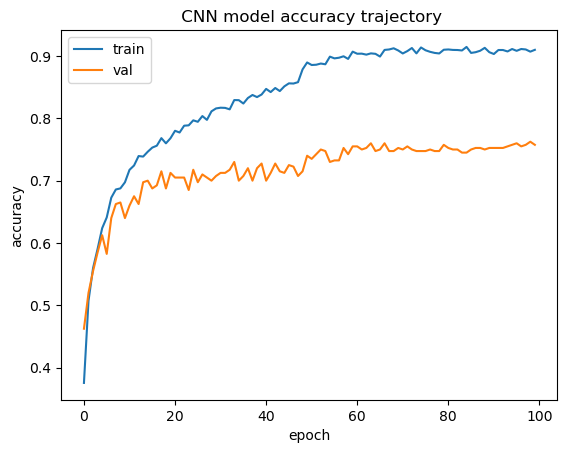

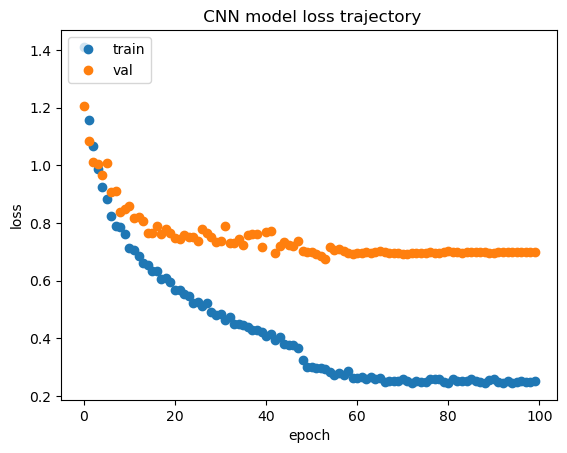

In [10]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title(' CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title(' CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
## Testing the hybrid CNN-LSTM model

cnn_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the  CNN model:',cnn_score[1])

Test accuracy of the  CNN model: 0.7494356632232666


In [12]:
model = keras.models.load_model('models4/checkpoint_118_0.74')

In [13]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

ValueError: in user code:

    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/mohammadakbarnezhad/opt/anaconda3/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 250, 1, 22), found shape=(None, 22, 250, 1)
